# Temporal and Spatial DataMining

## Exercise_06_Similarity

In [164]:
import math
import numpy as np
import matplotlib.pyplot as plt
from utils.TimeSeries import TS_1, TS_2
from scipy.linalg import norm
from matplotlib import cm
plt.style.use('ggplot')

### Task 1: DTW

**a)** Understanding DTW

Explain the procedure of the DTW algorithm 

>**Tip:** Take a look at the lecture notes, in "Information Retrieval for Music and Motion" by Müller (Chapter 4, as an e-book in the library), in the "Everything you know about Dynamic Time Warping is Wrong" by Ratanamahatana and Keogh, in "Exact Indexing of Dynamic Time Warping" by Keogh.)

**Q1.** What is a "local cost function"?


 **---  Your Text Here ----** 


**Q2.** What is a "DTW matrix"?


Distances to get to get to (i,j) from (0,0) in the matrix.
Minimal sum of distances to get to (i,j) from (0,0) in the matrix.


**Q3.** What is a warping path?

mappings between the two time series that minimizes the distance between them.


**Q4.** What is indexing and what are "lower bounds"?

indexing:

lower bounds: limits path to certain area close to the diagonal

**Q5.(UPDATE)** In which cases is it possible to obtain more than one warping path when calculating the similarity of two Time Series? What is the difference between the obtained paths?

if there are multiple minimum values in the DTW matrix, there are multiple warping paths. 
The difference between the paths is that they map different elements onto each other.

**Q6.** Is DTW robust against outliers? (that is, do outliers change the DTW value?)

Yes, bc if outliers create a big distance, the path will be adjusted to avoid the outlier.

**Q7.** What is the difference between norm and metric?


 **---  Your Text Here ----** 


**Q8.** Is Euclidean Distance a Metric? What must be fulfilled to call a function  $d(\mathbf{x},\mathbf{y})$ a metric?

- non-negativity
- only zero if x=y
- triangle inequality 

**Q9.** Is DTW a metric?


 **---  Your Text Here ----** 


**b)** Implement the calculation of the accumulated cost matrix in the function **dtw**. Then execute the function with the given **x** and **y** values.

In [165]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = np.inf
    D0[1:, 0] = np.inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()

    # accumulate cost matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])

    if len(x)==1:
        path = np.zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), np.zeros(len(x))
    else:
        path = _traceback(D0)
        
    return D1[-1, -1] / sum(D1.shape), C, D1, path

def _traceback(D):
    i, j = np.array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = np.argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)


In [166]:
t1,c = TS_1(x1=5, samples=50)
t2,d = TS_2(x1=5, samples=40)

x=c.reshape(-1,1)
y=d.reshape(-1,1)

In [167]:
# TODO: delete
def simple_distance(X1, X2, p):
    return np.sum(np.abs(X1-X2)**p)**(1/p)

# plot the accumulated cost martix and the wrap path
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: simple_distance(x, y, 2))
print(acc)

[[ 0.5         1.13008248  2.11746912 ... 14.17909305 14.75682496
  15.13917577]
 [ 0.81234415  0.94242663  1.74215743 ... 13.33237175 13.72244781
  13.91714277]
 [ 0.92248733  0.83228345  1.20952691 ... 13.67797493 13.36478303
  13.5925754 ]
 ...
 [15.72647744 15.85655992 16.34394656 ...  9.27972124  9.94372902
  10.25239479]
 [16.08350575 16.21358823 16.70097487 ...  8.87709816  9.31185838
   9.5512375 ]
 [16.2602772  16.39035968 16.87774632 ...  8.89110255  9.13160152
   9.19072378]]


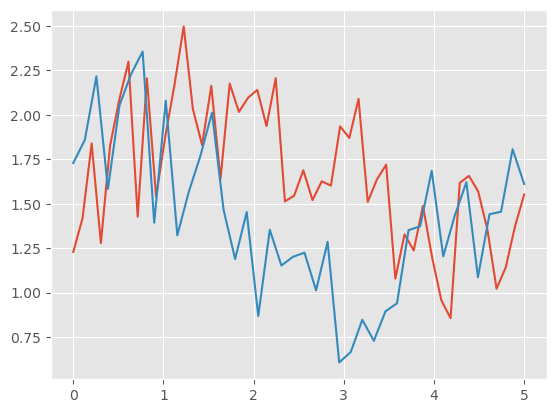

In [168]:
plt.plot(t1,c)
plt.plot(t2,d)

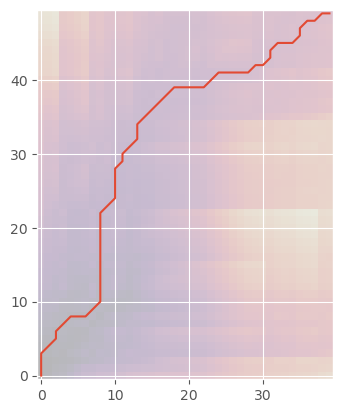

In [169]:
import seaborn as sns
def simple_distance(X1, X2, p):
    return np.sum(np.abs(X1-X2)**p)**(1/p)

# plot the accumulated cost martix and the wrap path
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: simple_distance(x, y, 2))


ax = plt.imshow(acc.reshape((len(x), len(y))),cmap="magma",origin="lower", alpha=0.2)
X, Y = path
plt.plot(Y, X)

### Task 2: LCSS

**a)** Implement the function **lcss** and output the longest subsequence of the two given sequences.

**Hint**:
[The lcss function defined](https://en.wikipedia.org/wiki/Longest_common_subsequence_problem):

1. $lcss(x_i, y_i)=\varnothing$, if $i = 0$ or $j = 0$
2. $lcss(x_i, y_i)=lcss(x_{i-1}, y_{j-1})^{\wedge}x_i$, if $i,j > 0$ and $x_i=y_j$
3. $lcss(x_i, y_i)=max\{lcss(x_i, y_{j-1}), lcss(x_{i-1}, y_j)\}$, if $i,j > 0$ and $x_i\neq y_j$


In [170]:
def lcss(x, y):
    '''
    x: a string with length of N
    y: a string with length of M
    Output: the longest subsequences.
    '''
    matrix = [''] * (len(x) + 1)
    for index_x in range(len(matrix)):
        matrix[index_x] = [''] * (len(y) + 1)
    
    for r in range(len(x)):
        for c in range(len(y)):
            if x[r] == y[c]:
                matrix[r+1][c+1] = matrix[r][c] + x[r]
            else:
                matrix[r+1][c+1] = max(matrix[r][c+1], matrix[r+1][c], key=len)
    
    print(matrix)
    return matrix[len(x)][len(y)]

In [171]:
x = "abcdef"
y = "adabceqdf"
print('The longest subsequences is:', lcss(x, y))

[['', '', '', '', '', '', '', '', '', ''], ['', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'], ['', 'a', 'a', 'a', 'ab', 'ab', 'ab', 'ab', 'ab', 'ab'], ['', 'a', 'a', 'a', 'ab', 'abc', 'abc', 'abc', 'abc', 'abc'], ['', 'a', 'ad', 'ad', 'ab', 'abc', 'abc', 'abc', 'abcd', 'abcd'], ['', 'a', 'ad', 'ad', 'ab', 'abc', 'abce', 'abce', 'abcd', 'abcd'], ['', 'a', 'ad', 'ad', 'ab', 'abc', 'abce', 'abce', 'abcd', 'abcdf']]
The longest subsequences is: abcdf


>LCSS Matrix:

```
[['', '', '', '', '', '', '', '', '', ''],
 ['', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 ['', 'a', 'a', 'a', 'ab', 'ab', 'ab', 'ab', 'ab', 'ab'],
 ['', 'a', 'a', 'a', 'ab', 'abc', 'abc', 'abc', 'abc', 'abc'],
 ['', 'a', 'ad', 'ad', 'ab', 'abc', 'abc', 'abc', 'abcd', 'abcd'],
 ['', 'a', 'ad', 'ad', 'ab', 'abc', 'abce', 'abce', 'abcd', 'abcd'],
 ['', 'a', 'ad', 'ad', 'ab', 'abc', 'abce', 'abce', 'abcd', 'abcdf']]
```

### Task 3: ED

**a)** Implement the function to calculate edit distance based on the following formulas:


1. $dist1 = ED(i-1, j-1)$, if $x_i=y_i$
2. $dist2 = ED(i-1, j-1) + 1$, (replace)
3. $dist3 = ED(i, j-1) + 1$, (insert)
4. $dist4 = ED(i-1, j) + 1$, (delete)

$ED(i,j) = min\{dist1, dist2, dist3, dist4\}$, with $ED(0,0)=0$, $ED(i,0)=i$ and $ED(0,j)=j$

In [172]:
def edit_distance(str_a,str_b):
    """
    :param str_a:
    :param str_b:
    :return: Edit distance
    """
    str_a=str_a.lower()
    str_b=str_b.lower()
    matrix_ed=np.zeros((len(str_a)+1,len(str_b)+1),dtype=int)
    matrix_ed[0]=np.arange(len(str_b)+1)
    matrix_ed[:,0] = np.arange(len(str_a) + 1)
    
    for row in range(1, len(str_a) + 1):
        for col in range(1, len(str_b) + 1):
            if str_a[row - 1] == str_b[col - 1]:    # equal
                matrix_ed[row,col] = matrix_ed[row-1,col-1]
            else:   # not equal
                matrix_ed[row,col] = min(matrix_ed[row-1,col-1], matrix_ed[row-1,col], matrix_ed[row,col-1]) + 1
        
    print(matrix_ed)
    return matrix_ed[-1,-1]

**b)** Calculate the edit distance between x1 and x2.

In [173]:
x1 = 'love'
x2 = 'lolpe'

print('The edit distance between x1 and x2 is:', edit_distance(x1, x2))

[[0 1 2 3 4 5]
 [1 0 1 2 3 4]
 [2 1 0 1 2 3]
 [3 2 1 1 2 3]
 [4 3 2 2 2 2]]
The edit distance between x1 and x2 is: 2


>ED Matrix:

```
array([[0, 1, 2, 3, 4, 5],
       [1, 0, 1, 2, 3, 4],
       [2, 1, 0, 1, 2, 3],
       [3, 2, 1, 1, 2, 3],
       [4, 3, 2, 2, 2, 2]])
```

### Task 4: TWED (Bonus)

**a)** Read the paper entitled "Time Warp Edit Distance with Stiffness Adjustment for Time Series Matching" https://ieeexplore.ieee.org/document/4479483 of Pierre-François Marteau 
> Sections: **3, 3.1, and 4.1 - 4.4**

> Furthermore: Wikipedia [article](https://de.wikipedia.org/wiki/Time_Warp_Edit_Distance) on TWED. 

**b)** What is "Stiffness Adjustment"?

The stiffness $\nu$ expresses the cost/penalty of changing the time alignment.
- Lower $\nu$ allows more flexibility. 
- Higher $\nu$ penalizes time warping

**c)** Is TWED a metric? 

Yes, because for $\nu \geq 0$ it fulfills the characteristics of a metric:
- $\delta_{\lambda, \nu}(A, B) \geq 0$
- $\delta_{\lambda, \nu}(A, B) = 0 \iff A = B$
- $\delta_{\lambda, \nu}(A, B) \leq \delta_{\lambda, \nu}(A, C) + \delta_{\lambda, \nu}(C, B)$


**d)** Implement the TWED function. 

In [174]:
def init_matrix(data):
    for i in range(len(data)):
        data[i][0] = float('inf')
    for i in range(len(data[0])):
        data[0][i] = float('inf')
    data[0][0] = 0
    return data

def lp_dist(time_pt_1, time_pt_2, p=2):
    """ Computes the LP distance between two points """
    return np.sum(np.abs(time_pt_1-time_pt_2)**p) ** (1/p)


def TWED(t1, t2, lam, nu):
    """"
    Requires: 
    t1: multivariate time series in numpy matrix format. 
    t2: multivariate time series in numpy matrix format. 
    lam: penalty lambda parameter, 
    nu: stiffness coefficient
    
    Returns the TWED distance between the two time series. 
    """
    t1_time, t1_data = t1
    t2_time, t2_data = t2

    t1_data = t1_data.reshape(-1,1)
    t2_data = t2_data.reshape(-1,1)

    # insert zero at the beginning
    t1_time = np.insert(t1_time, 0, 0, axis=0)
    t1_data = np.insert(t1_data, 0, 0, axis=0)
    t2_time = np.insert(t2_time, 0, 0, axis=0)
    t2_data = np.insert(t2_data, 0, 0, axis=0)

    N, M = len(t1_time), len(t2_time)
    result = np.zeros((N, M))
    result[0, 1:] = np.inf
    result[1:, 0] = np.inf

    for i in range(1, N):
        for j in range(1, M):
            # delete_A
            c1 = (
                result[i-1, j] 
                + lp_dist(t1_data[i-1], t1_data[i]) 
                + nu * (t1_time[i] - t1_time[i-1]) 
                + lam
            )

            # detete_B
            c2 = (
                result[i, j-1] 
                + lp_dist(t2_data[j-1], t2_data[j])
                + nu * (t2_time[j] - t2_time[j-1]) 
                + lam
            )

            # match
            c3 = (
                result[i-1, j-1] 
                + lp_dist(t1_data[i], t2_data[j]) 
                + lp_dist(t1_data[i-1], t2_data[j-1]) 
                + nu * (np.abs(t1_time[i] - t2_time[j]) + np.abs(t1_time[i-1] - t2_time[j-1]))
            )

            result[i, j] = min(c1, c2, c3)

    return result[N-1, M-1]

In [175]:
ts_1 = TS_1(x1=5, samples=50)
ts_2 = TS_2(x1=5, samples=50)

# calculate the distance between time series ts_1 and ts_2
TWED(ts_1, ts_2, lam=0.01, nu=0.01)

15.91264897151783

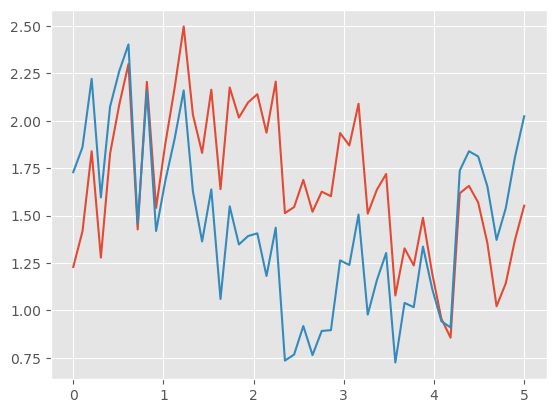

In [176]:
plt.plot(ts_1[0], ts_1[1])
plt.plot(ts_2[0], ts_2[1])

In [177]:
# try different values for lam and nu
lambdas = [0, 0.25, 0.5, 0.75, 1]
nus = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1]

distances = np.array([[TWED(ts_1, ts_2, lam, nu) for lam in lambdas] for nu in nus])

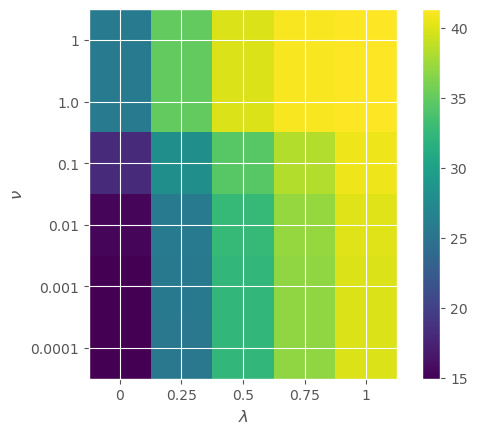

In [178]:
plt.imshow(distances, origin='lower')
plt.xlabel('$\lambda$')
plt.ylabel('$\\nu$')
plt.xticks(ticks=range(len(lambdas)), labels=lambdas)
plt.yticks(ticks=range(len(nus)), labels=nus)
plt.colorbar()
plt.show()